In [1]:
import numpy as np

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import matplotlib.pyplot as plt

from sklearn import svm

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [2]:
# Hyperparameters to be tuned (XGB without tuning)

param_grid_svm = {'C': [0.1,1, 10, 100], 
              'gamma': [1,0.1,0.01,0.001],
               'kernel': ['rbf', 'poly']}

param_grid_lda = {'solver': ['svd', 'lsqr', 'eigen']} 

In [3]:
def buildRocCurves(class_of_interest, X, y, trackAccuracies: list, 
                   classifier_type='lda', num_splits=10, showPlot=True):
    """
    class_of_interest: class for ROCs (class vs rest)
    X, y : input data features and data labels
    classifier_type: ['lda', 'xgb', 'svm']  ### xgb is temp. unsupported
    num_splits: number of splits for K-folds
    """
    n_splits = num_splits # suggested 6 
    # new split set each time 
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=np.random.randint(1, 200))
    if classifier_type == 'lda':
        classifier = LinearDiscriminantAnalysis()
    elif classifier_type == 'xgb':
        classifier = XGBClassifier(objective='multi:softmax')
    elif classifier_type == 'svm':
        classifier = svm.SVC(probability=True, random_state=np.random.randint(1, 200))

    # |------------------------------------------------------------------------------------------------------------------|
    # |IDEA: tune hyperparameters of a classifier on one set, and the rest of set input into cv folds? (train / cv sets) |
    # |------------------------------------------------------------------------------------------------------------------|

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))

    for fold, (train, test) in enumerate(cv.split(X, y)):  
        if classifier_type == 'xgb':
            label_binarizer = LabelBinarizer().fit(y[train])
            y_onehot_test = label_binarizer.transform(y[test])
            le = LabelEncoder()
            y[train] = le.fit_transform(y[train])
            y[test] = le.transform(y[test])
            print(y[train])
            print(y[test])

        classifier.fit(X[train], y[train])

        y_score = classifier.predict_proba(X[test]) # get probabilities for each class 
        
#         if classifier_type == 'xgb':
# #             label_binarizer = LabelBinarizer().fit(y[train].astype('int'))
# #             y_onehot_test = label_binarizer.transform(y[test].astype('int'))
#             label_binarizer = LabelBinarizer().fit(y_tr_xgb)
#             y_onehot_test = label_binarizer.transform(y_test_xgb)
        if classifier_type != 'xgb':
            label_binarizer = LabelBinarizer().fit(y[train])
            y_onehot_test = label_binarizer.transform(y[test])

        class_of_interest = class_of_interest 
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

        viz = RocCurveDisplay.from_predictions(
          y_onehot_test[:, class_id],
          y_score[:, class_id],
          name=f"{class_of_interest} vs the rest",
          color="darkorange",
          ax = ax,
          #label=None # not to display in legend each fold AUC, otherwise uncomment name var
          #plot_chance_level=True,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        # Calculate accuracy for the current fold
        y_pred = classifier.predict(X[test])
        bal_accuracy = balanced_accuracy_score(y[test], y_pred)
        trackAccuracies.append(bal_accuracy)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
      mean_fpr,
      mean_tpr,
      color="b",
      label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
      lw=2,
      alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    
    ax.fill_between(
      mean_fpr,
      tprs_lower,
      tprs_upper,
      color="grey",
      alpha=0.2,
      label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
      xlabel="False Positive Rate",
      ylabel="True Positive Rate",
      title=f"Mean ROC curve with variability\n(Positive label '{class_of_interest}')",
    )
    ax.legend(loc="lower right")
    
    if showPlot == True:
        plt.show()
    elif showPlot == False:
        plt.close()

    return mean_fpr, mean_tpr, std_auc # return values for ploting mean ROC curve for this CV-fold 

# Read data.

In [4]:
import pickle

with open('../data/features_kruskal_wallis/sel_features_atm_aec_plv_cc_datasets.pkl', 'rb') as f:
    sel_feats = pickle.load(f)

In [5]:
df_plv = sel_feats['df_plv_flat.csv']

In [6]:
X = df_plv.iloc[:, :-1]
y = df_plv.iloc[:, -1]

X = np.array(X)
y = np.array(y)

In [7]:
y[::10]

array(['PD_off', 'PD_off', 'MS', 'MS', 'MCI', 'MCI', 'MCI', 'SLA', 'SLA',
       'SLA', 'SLA'], dtype=object)

In [8]:
#buildRocCurves("MS", X, y, classifier_type='svm', showPlot=True);

### Cycle for Repetitions
- use function for calculating one CV-fold set to make N repetitions 
- save mean ROCs for each CV-fold set , in total: N ROCs (N TPRs, N FPRs)
- calculate mean of these 10 mean ROCs and display with conf interval etc.

In [9]:
def RepetitiveRocs(class_interest, X, y, trackAccuracies, n_repeats=10, num_splits=6, classifier_type='lda',
                   displayConfInterval=False):
    """
    Variables:
    rocs_dict : dict to save mean FPRs, TPRs, std of each CV-fold set (num.of CV-folds = n_repeats)
    """
    rocs_dict = dict() 
    for i in range(n_repeats):
        rocs_dict[f'repetition_{i}'] = buildRocCurves(class_of_interest=class_interest, X=X, y=y, 
                                                      trackAccuracies=trackAccuracies,
                                                     classifier_type=classifier_type, num_splits=num_splits, 
                                                      showPlot=False)
        
    auc_vals = [auc(rocs_dict[f'repetition_{i}'][0], 
                    rocs_dict[f'repetition_{i}'][1]) for i in range(n_repeats)]
        
    std_auc = np.std(auc_vals) # std of all mean AUCs
    
    # Mean ROC
    mean_auc = np.mean(auc_vals)
        
    # Plotting all mean ROCs from CV-fold sets
    fig, ax = plt.subplots(figsize=(6, 6))

    for i in range(n_repeats):
        std_auc_rep = rocs_dict[f'repetition_{i}'][2]
        ax.plot(rocs_dict[f'repetition_{i}'][0], rocs_dict[f'repetition_{i}'][1], 
                label=f'Rep. {i+1} (AUC = {auc_vals[i]:.2f} $\\pm$ {std_auc_rep:.2f})', 
                color='gray')
        
    # Plot one mean ROC among all mean ROCs
    ax.plot(np.mean([rocs_dict[f"repetition_{i}"][0] for i in range(n_repeats)], axis=0), 
             np.mean([rocs_dict[f"repetition_{i}"][1] for i in range(n_repeats)], axis=0), 
             color='red', label=f'Mean (AUC = {mean_auc:.2f} $\\pm$ {std_auc:.2f})', 
             linewidth=3)
        
    if displayConfInterval:
        tprs_upper = np.minimum(np.mean([rocs_dict[f"repetition_{i}"][1] for i in range(n_repeats)], 
                                        axis=0) + np.std([rocs_dict[f"repetition_{i}"][1] for i in range(n_repeats)], axis=0), 1)
        tprs_lower = np.maximum(np.mean([rocs_dict[f"repetition_{i}"][1] for i in range(n_repeats)], 
                                        axis=0) - np.std([rocs_dict[f"repetition_{i}"][1] for i in range(n_repeats)], axis=0), 0)
        mean_fpr = np.mean([rocs_dict[f"repetition_{i}"][0] for i in range(n_repeats)], axis=0)

        ax.fill_between(
          mean_fpr,
          tprs_lower,
          tprs_upper,
          color="grey",
          alpha=0.2,
          label=r"$\pm$ 1 std. dev.",
        )
    ax.legend()
    plt.title(f'ROC of {class_interest} (One-vs-All), {n_repeats} repeats, {num_splits} folds')
    plt.savefig("../figures/ROC_" + classifier_type + '_' + class_interest + '.png', dpi=600)
    plt.show()

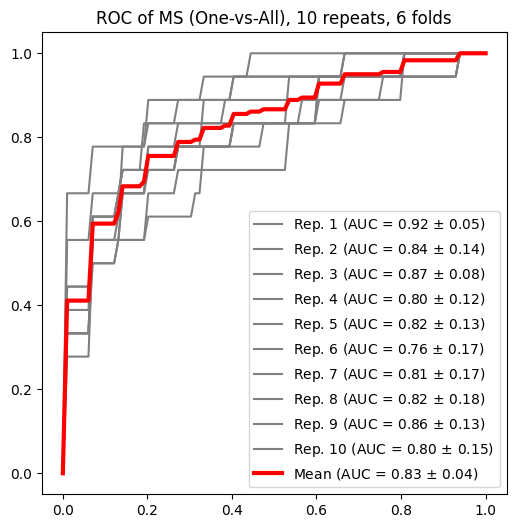

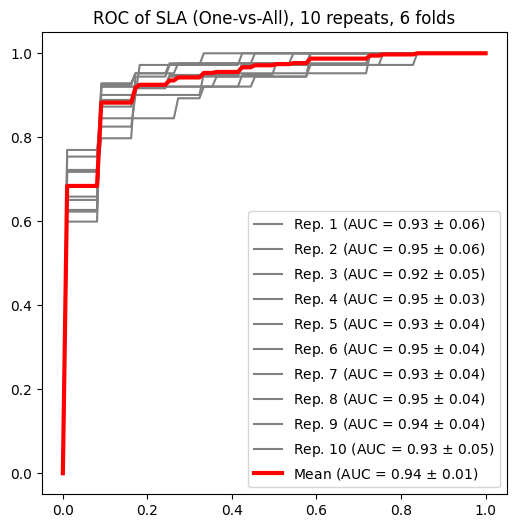

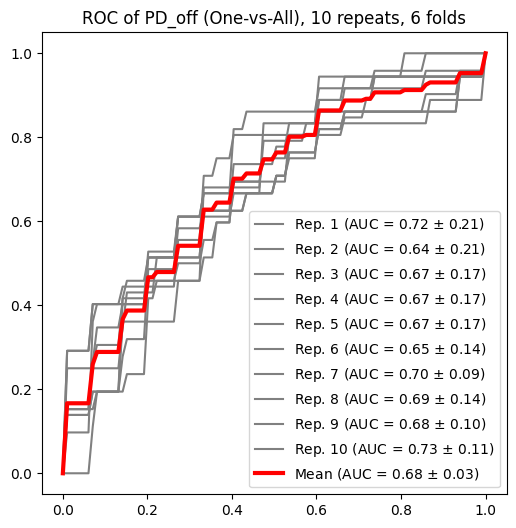

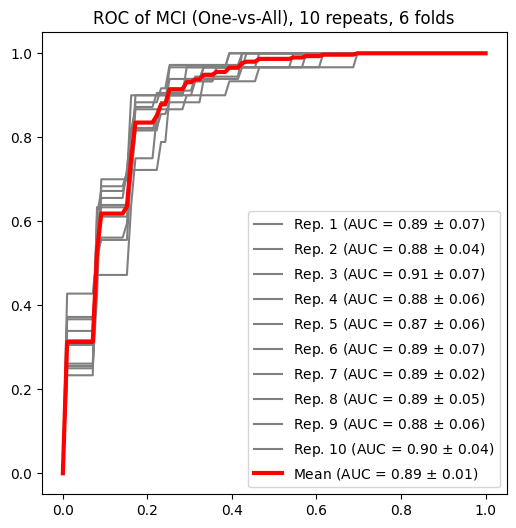

In [10]:
balanced_accuracies_ms = []
balanced_accuracies_sla = []
balanced_accuracies_pd = []
balanced_accuracies_mci = []

RepetitiveRocs("MS", X, y, balanced_accuracies_ms, n_repeats=10, num_splits=6, classifier_type='lda')
RepetitiveRocs("SLA", X, y, balanced_accuracies_sla, n_repeats=10, num_splits=6, classifier_type='lda')
RepetitiveRocs("PD_off", X, y, balanced_accuracies_pd, n_repeats=10, num_splits=6, classifier_type='lda')
RepetitiveRocs("MCI", X, y, balanced_accuracies_mci, n_repeats=10, num_splits=6, classifier_type='lda')

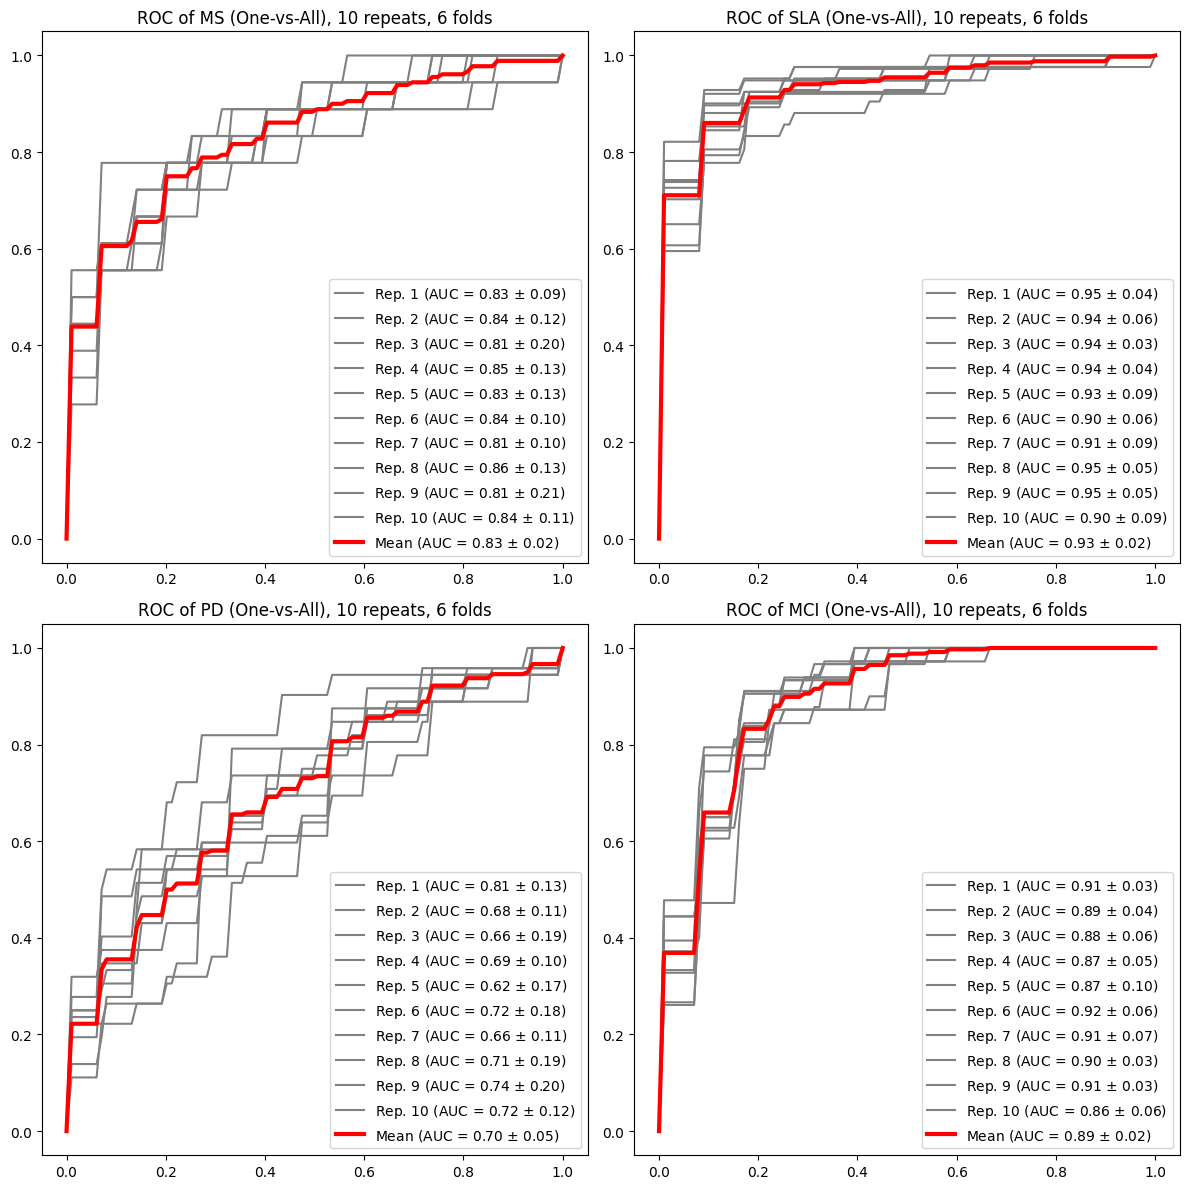

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Define function to plot repetitive ROCs
def plot_repetitive_rocs(ax, class_interest, X, y, trackAccuracies, n_repeats=10, num_splits=6, classifier_type='lda'):
    rocs_dict = dict() 
    for i in range(n_repeats):
        rocs_dict[f'repetition_{i}'] = buildRocCurves(class_of_interest=class_interest, X=X, y=y, 
                                                      trackAccuracies=trackAccuracies,
                                                      classifier_type=classifier_type, num_splits=num_splits, 
                                                      showPlot=False)
        
    auc_vals = [auc(rocs_dict[f'repetition_{i}'][0], rocs_dict[f'repetition_{i}'][1]) for i in range(n_repeats)]
        
    std_auc = np.std(auc_vals) 
    mean_auc = np.mean(auc_vals)
        
    for i in range(n_repeats):
        std_auc_rep = rocs_dict[f'repetition_{i}'][2]
        ax.plot(rocs_dict[f'repetition_{i}'][0], rocs_dict[f'repetition_{i}'][1], 
                label=f'Rep. {i+1} (AUC = {auc_vals[i]:.2f} $\\pm$ {std_auc_rep:.2f})', 
                color='gray')
        
    ax.plot(np.mean([rocs_dict[f"repetition_{i}"][0] for i in range(n_repeats)], axis=0), 
            np.mean([rocs_dict[f"repetition_{i}"][1] for i in range(n_repeats)], axis=0), 
            color='red', label=f'Mean (AUC = {mean_auc:.2f} $\\pm$ {std_auc:.2f})', 
            linewidth=3)
        
    ax.legend()
    if class_interest == 'PD_off':
        ax.set_title(f'ROC of PD (One-vs-All), {n_repeats} repeats, {num_splits} folds')
    else:
        ax.set_title(f'ROC of {class_interest} (One-vs-All), {n_repeats} repeats, {num_splits} folds')

# Call the function for each class of interest and plot it in corresponding subplot
plot_repetitive_rocs(axs[0, 0], "MS", X, y, balanced_accuracies_ms)
plot_repetitive_rocs(axs[0, 1], "SLA", X, y, balanced_accuracies_sla)
plot_repetitive_rocs(axs[1, 0], "PD_off", X, y, balanced_accuracies_pd)
plot_repetitive_rocs(axs[1, 1], "MCI", X, y, balanced_accuracies_mci)

plt.tight_layout()
plt.savefig("../figures/All_ROCs_LDA.png", dpi=600)
plt.show()

### ********************************************************************************************************************************

In [12]:
# roc_vals_pd = dict()

# for i in range(5):
#     roc_vals_pd[f'repetition_{i}'] = buildRocCurves("MS", X, y, classifier_type='lda');

In [13]:
# auc_vals = [auc(roc_vals_pd[f'repetition_{i}'][0], roc_vals_pd[f'repetition_{i}'][1]) for i in range(5)]

In [14]:
# std_auc = np.std(auc_vals)

In [15]:
# plt.plot(roc_vals_pd['repetition_0'][0], roc_vals_pd['repetition_0'][1])
# plt.plot(roc_vals_pd['repetition_1'][0], roc_vals_pd['repetition_1'][1])
# plt.plot(roc_vals_pd['repetition_2'][0], roc_vals_pd['repetition_2'][1])
# plt.plot(roc_vals_pd['repetition_3'][0], roc_vals_pd['repetition_3'][1])
# plt.plot(roc_vals_pd['repetition_4'][0], roc_vals_pd['repetition_4'][1])

# auc_val_rep_0 = auc(roc_vals_pd['repetition_0'][0], roc_vals_pd['repetition_0'][1])

# auc_val = auc(np.mean([roc_vals_pd[f"repetition_{i}"][0] for i in range(5)], axis=0), 
#               np.mean([roc_vals_pd[f"repetition_{i}"][1] for i in range(5)], axis=0))

# plt.plot(np.mean([roc_vals_pd[f"repetition_{i}"][0] for i in range(5)], axis=0), 
#          np.mean([roc_vals_pd[f"repetition_{i}"][1] for i in range(5)], axis=0), 
#          color='red', label=f'Mean (AUC = {auc_val:.2f} +- {std_auc:.2f})', 
#          linewidth=3)
# plt.legend()
# plt.show()

In [16]:
# buildRocCurves("MCI", X, y, classifier_type='lda', num_splits=6);
# buildRocCurves("MS", X, y, classifier_type='lda', num_splits=6);
# buildRocCurves("PD_off", X, y, classifier_type='lda', num_splits=6);
# buildRocCurves("SLA", X, y, classifier_type='lda', num_splits=6);

In [17]:
# buildRocCurves("MCI", X, y, classifier_type='svm', num_splits=6);
# buildRocCurves("MS", X, y, classifier_type='svm', num_splits=6);
# buildRocCurves("PD_off", X, y, classifier_type='svm', num_splits=6);
# buildRocCurves("SLA", X, y, classifier_type='svm', num_splits=6);